In [9]:
from seaborn import distributions
from functools import partial
import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics, model_selection
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy
from pgmpy.estimators import HillClimbSearch, TreeSearch, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.base import DAG
from tqdm import tqdm

### rain		Bool
### temp       	Air Temperature 	                                      °C
### wetb		Wet Bulb Air Temperature			                °C
### dewpt		Dew Point Air Temperature					°C
### vappr		Vapour Pressure							hpa
### rhum		Relative Humidity						%
### msl		Mean Sea Level Pressure						hPa
### wdsp		Mean Hourly Wind Speed						kt


### Target: temp, vappr, dewpt, msl

In [10]:
df = pd.read_csv('../Data/clear_df.csv')
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,latitude,longitude,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp
0,51.476,-9.428,0.0,11.5,10.6,9.7,12.0,88.0,1031.1,6.0
1,54.228,-10.007,0.8,13.0,12.9,12.8,14.8,99.0,1013.0,4.0
2,55.372,-7.339,0.0,6.3,3.5,-1.2,5.6,58.0,1025.2,19.0
3,52.690,-8.918,0.0,8.5,6.2,3.1,7.6,69.0,1025.3,10.0
4,53.516,-6.660,0.0,13.6,11.3,9.1,11.6,74.0,1013.2,13.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4214711 entries, 0 to 4214710
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   latitude   float64
 1   longitude  float64
 2   rain       float64
 3   temp       float64
 4   wetb       float64
 5   dewpt      float64
 6   vappr      float64
 7   rhum       float64
 8   msl        float64
 9   wdsp       float64
dtypes: float64(10)
memory usage: 321.6 MB


In [12]:
variables_name = ['latitude', 'longitude', 'rain', 'wetb', 'rhum', 'wdsp']
variables = df[variables_name]
targets_name = ['temp', 'vappr', 'dewpt', 'msl']
targets = df[targets_name]

### Sampling

## Using inverse transform sampling

In [14]:
# Sampling from df
def inv_trans_sampling(data, num_samples=1000):
    #finding num bins
    bins = distributions._freedman_diaconis_bins(data.values)
    # creating curve p(x)
    hist, bin_edges = np.histogram(data.values, bins=bins, density=True)

    cum_values = np.zeros(bin_edges.shape)
    # integrating and saving square under the curve, because
    # F(x) = P(X <= x)
    cum_values[1:] = np.cumsum(hist * np.diff(bin_edges))
    #interpl
    inversed_cdf = partial(np.interp, xp=cum_values, fp=bin_edges)
    #creating sampling data
    uniform_values = np.random.rand(num_samples)
    return inversed_cdf(uniform_values), bins

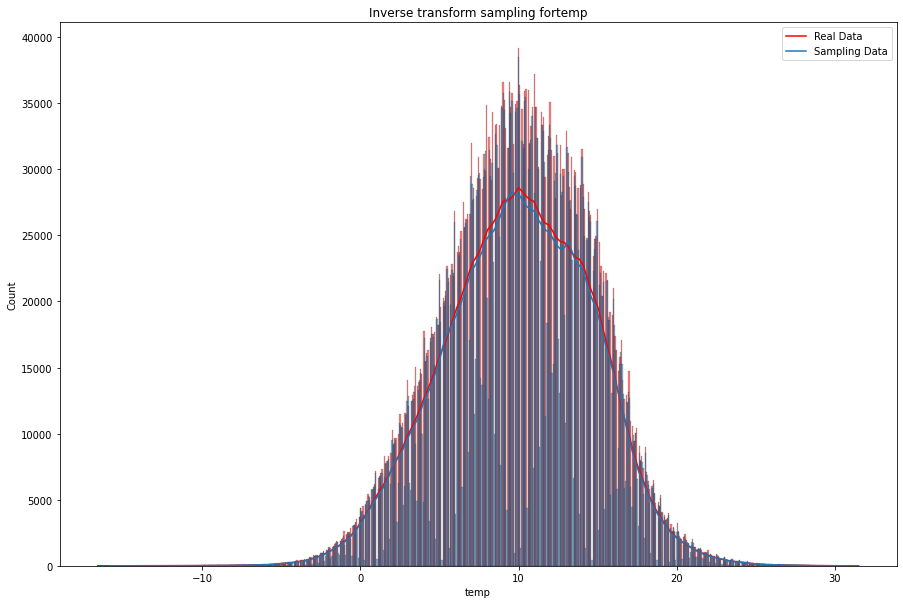

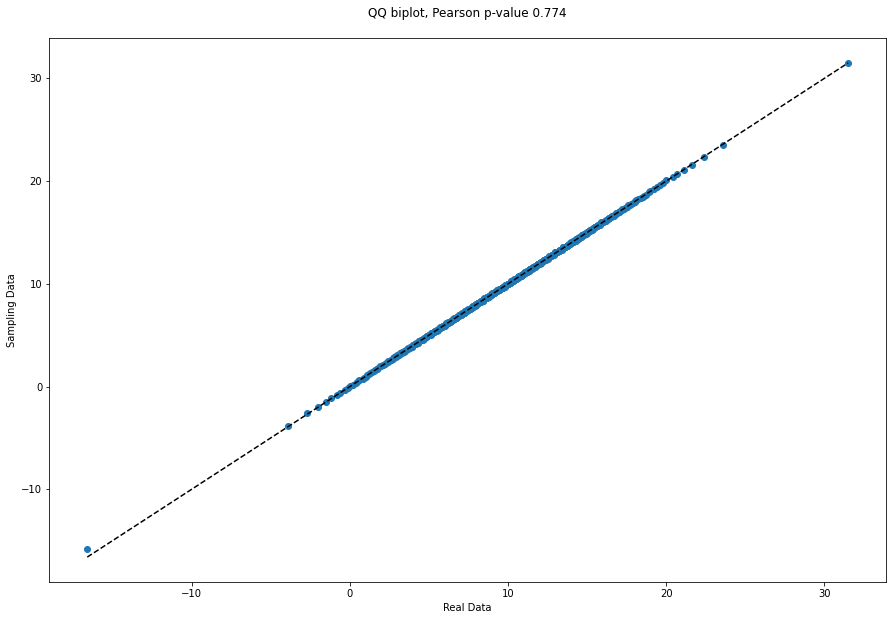

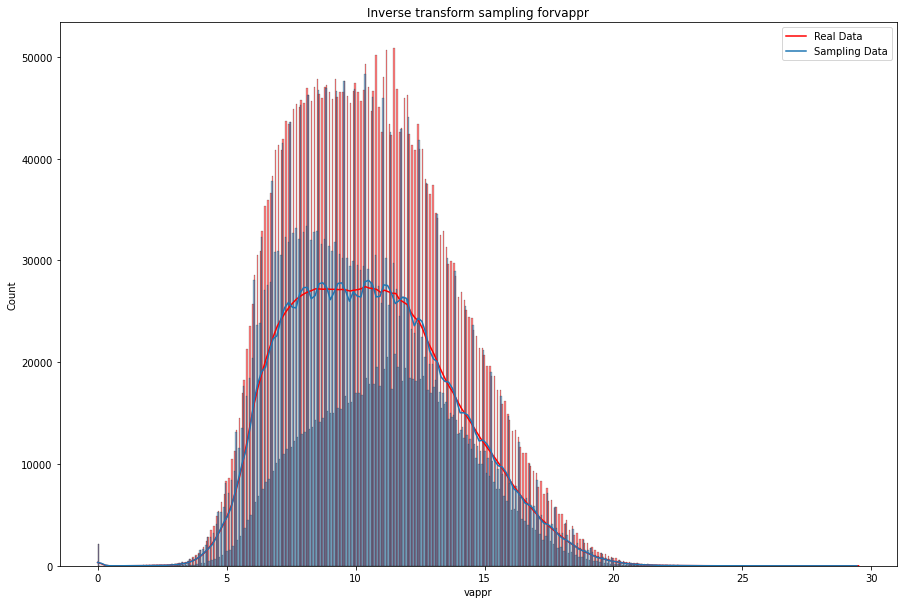

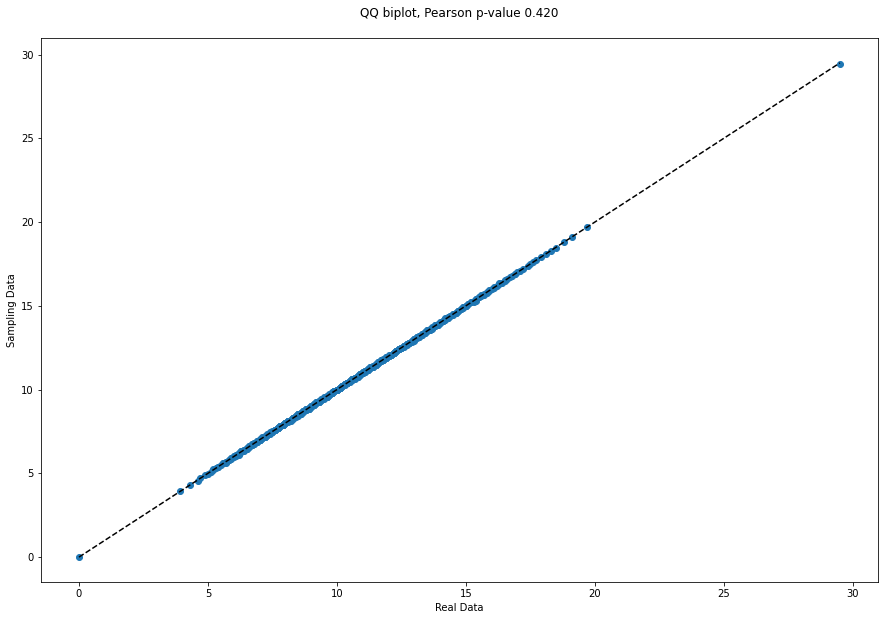

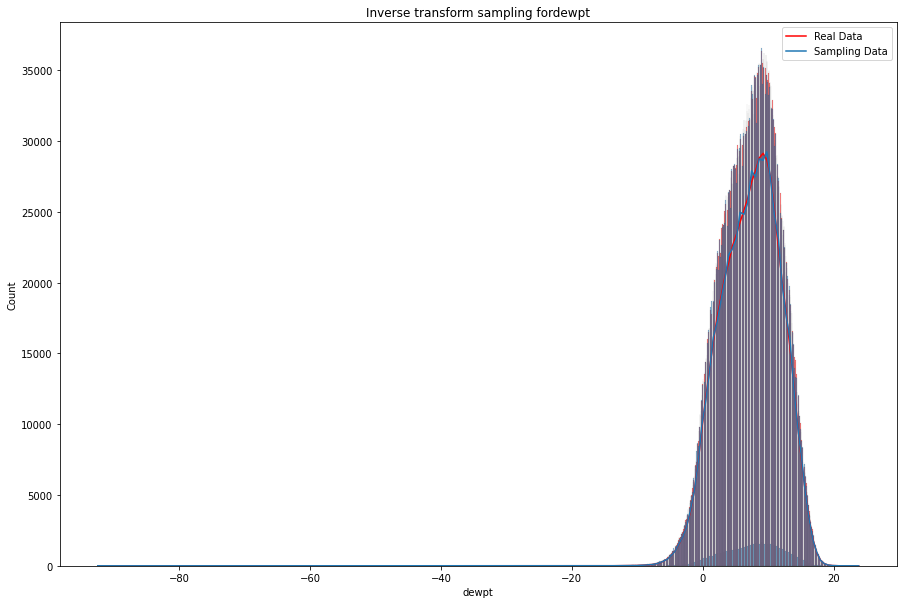

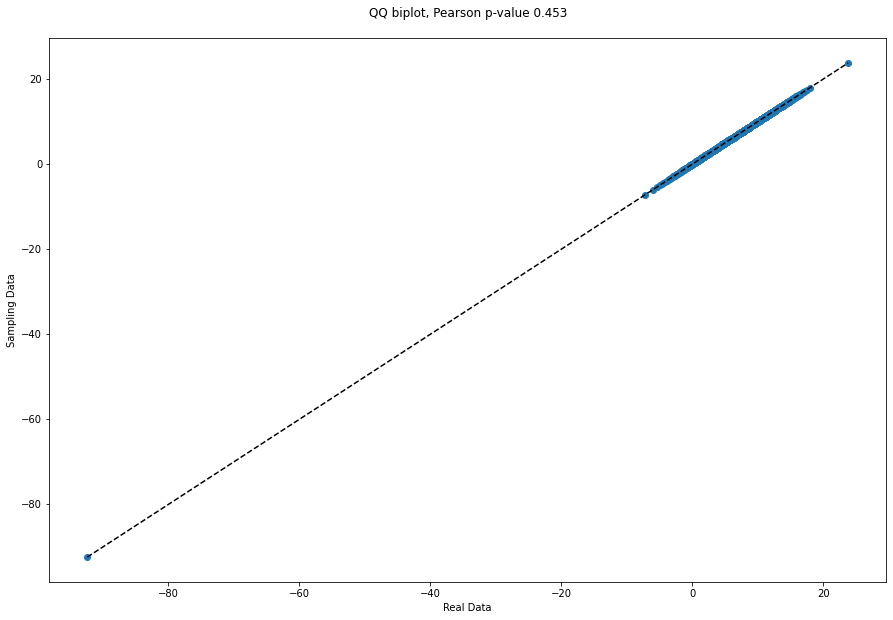

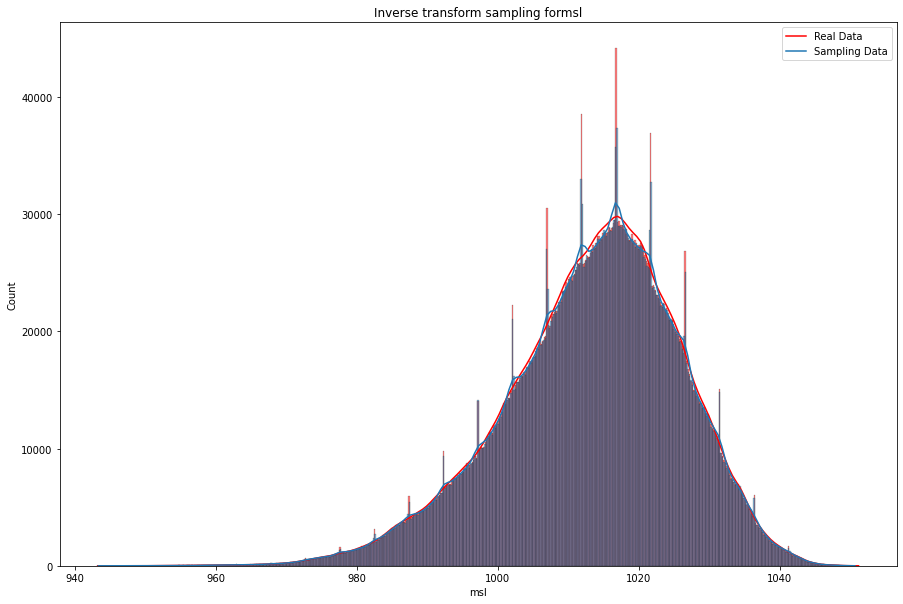

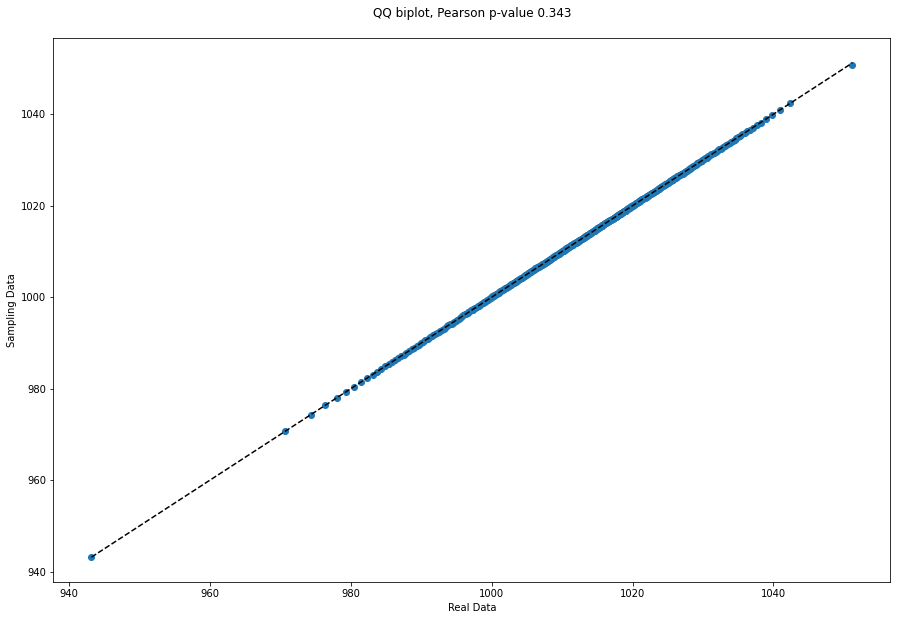

In [153]:
for name in targets_name:
    sampled, n_bins = inv_trans_sampling(df[name], num_samples=df[name].shape[0])

    percs = np.linspace(0, 100, n_bins)
    qn_gt = np.percentile(df[name], percs)
    qn_sampled = np.percentile(sampled, percs)

    p_stat, p_pv = scipy.stats.pearsonr(df[name], sampled)

    plt.figure(figsize=(15, 10))
    sns.histplot(df[name], bins=n_bins, kde=True, color='r')
    sns.histplot(sampled, bins=n_bins, kde=True)
    plt.legend(["Real Data", 'Sampling Data'])
    plt.title(f"Inverse transform sampling for{name}")
    plt.savefig(f'IV_plot_{name}', bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(15, 10))
    plt.plot(qn_gt, qn_sampled, ls="", marker="o", markersize=6)
    plt.plot(qn_gt, qn_gt, color="k", ls="--")
    plt.xlabel("Real Data")
    plt.ylabel("Sampling Data")
    plt.title(f"QQ biplot, Pearson p-value {p_pv:.3f}\n")
    plt.savefig(f'Probability_plot_{name}', bbox_inches='tight')
    plt.show()

## Using accept-reject

In [16]:
df['temp'].describe()

count    4.214711e+06
mean     1.001084e+01
std      4.666689e+00
min     -1.660000e+01
25%      6.900000e+00
50%      1.010000e+01
75%      1.340000e+01
max      3.150000e+01
Name: temp, dtype: float64

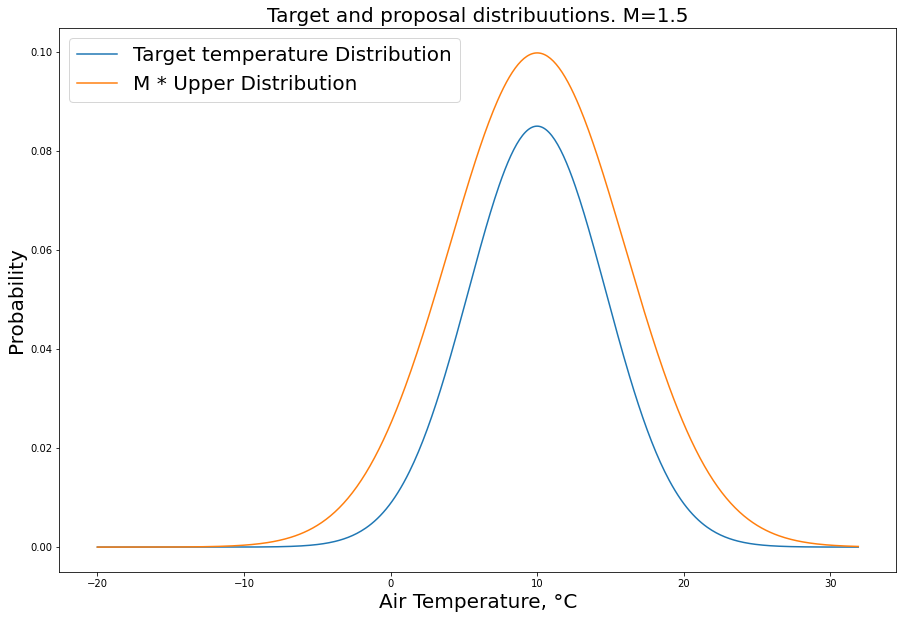

In [155]:
def g1(x, mu_, sigma_):
    return 1 / np.sqrt(2 * np.pi) / sigma_ * np.exp(-0.5 * ((x - mu_) / sigma_) ** 2)

def g(x, mu_, sigma_):
    return 1 / np.sqrt(2 * np.pi) / sigma_ * np.exp(-0.5 * ((x - mu_) / sigma_) ** 2)

M = 1.5

upper_params = 10, 6

plt.figure(figsize=(15, 10))
x_vals = np.arange(-20, 32, 0.1)
f_vals = [g1(x, 9.99195449792312, 4.69599208496842) for x in x_vals]
g_vals = g(x_vals, *upper_params)
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M * g_vals)
plt.xlabel('Air Temperature, °C', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.legend(['Target temperature Distribution', 'M * Upper Distribution'], fontsize=20)
plt.title("Target and proposal distribuutions. M=%s" % M, fontsize=20)
plt.savefig('Distib_temp', bbox_inches='tight')
plt.show()

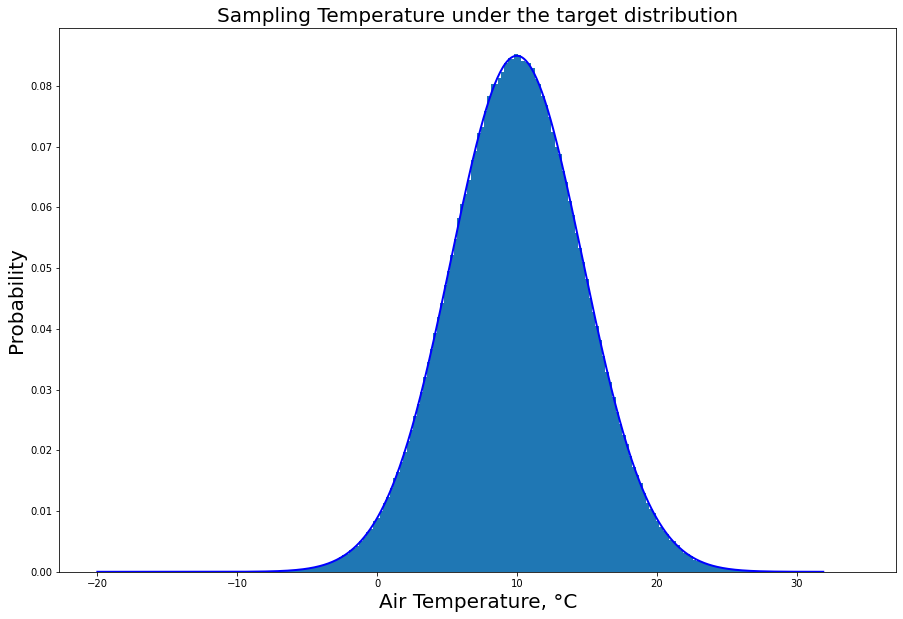

In [156]:
# collect all accepted samples here
samples = []

# try this many candidates
N = 2_000_000

for _ in range(N):
    # sample a candidate
    candidate = np.random.normal(*upper_params)

    # calculate probability of accepting this candidate
    prob_accept = g1(candidate, 9.99195449792312, 4.695992084968425) / (M * g(candidate, *upper_params))

    # accept with the calculated probability
    if np.random.random() < prob_accept:
        samples.append(candidate)

plt.figure(figsize=(15, 10))
plt.hist(samples, bins=200, density=True)
plt.xlabel('Air Temperature, °C', fontsize=20)
plt.plot(x_vals, f_vals, linewidth=2, color='b')
plt.ylabel('Probability', fontsize=20)
plt.title("Sampling Temperature under the target distribution", fontsize=20)
plt.savefig('dist_hist_temp', bbox_inches='tight')
plt.show()

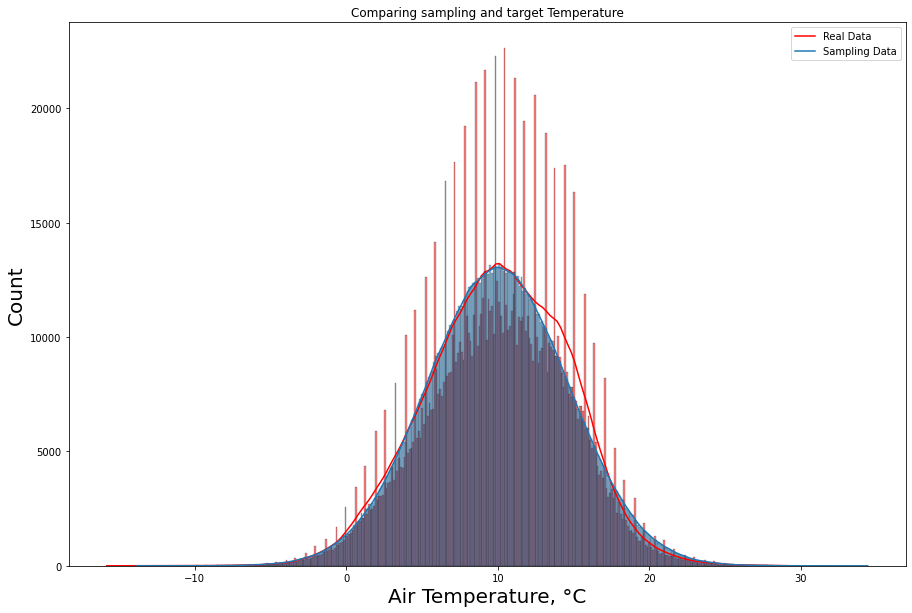

In [157]:
plt.figure(figsize=(15, 10))
sns.histplot(df['temp'].values[:len(samples)], kde=True, color='red')
sns.histplot(samples, kde=True)
plt.legend(["Real Data", 'Sampling Data'])
plt.title("Temperature.", fontsize=20)
plt.xlabel('Air Temperature, °C', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title(f"Comparing sampling and target Temperature")
plt.savefig('hist_temp', bbox_inches='tight')
plt.show()

0.6233596644314514


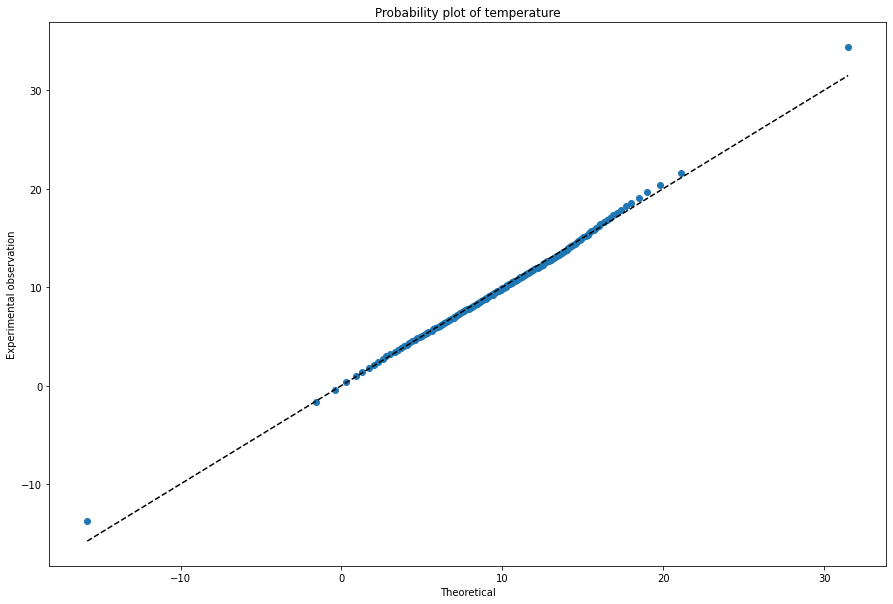

In [158]:
plt.figure(figsize=(15, 10))
percs = np.linspace(0, 100, 150)
qn_gt = np.percentile(df['temp'].values[:len(samples)], percs)
p_stat, p_pv = scipy.stats.pearsonr(df['temp'].values[:len(samples)], samples)
print(p_pv)
qn_sampled = np.percentile(samples, percs)
plt.plot(qn_gt, qn_sampled, ls="", marker="o", markersize=6)
plt.plot(qn_gt, qn_gt, color="k", ls="--")
plt.xlabel('Theoretical')
plt.ylabel('Experimental observation')
plt.title("Probability plot of temperature")
plt.savefig('Probability_plot_temp', bbox_inches='tight')
plt.show()

In [150]:
df['vappr'].describe()

count    4.214711e+06
mean     1.060765e+01
std      3.150282e+00
min      0.000000e+00
25%      8.100000e+00
50%      1.040000e+01
75%      1.280000e+01
max      2.950000e+01
Name: vappr, dtype: float64

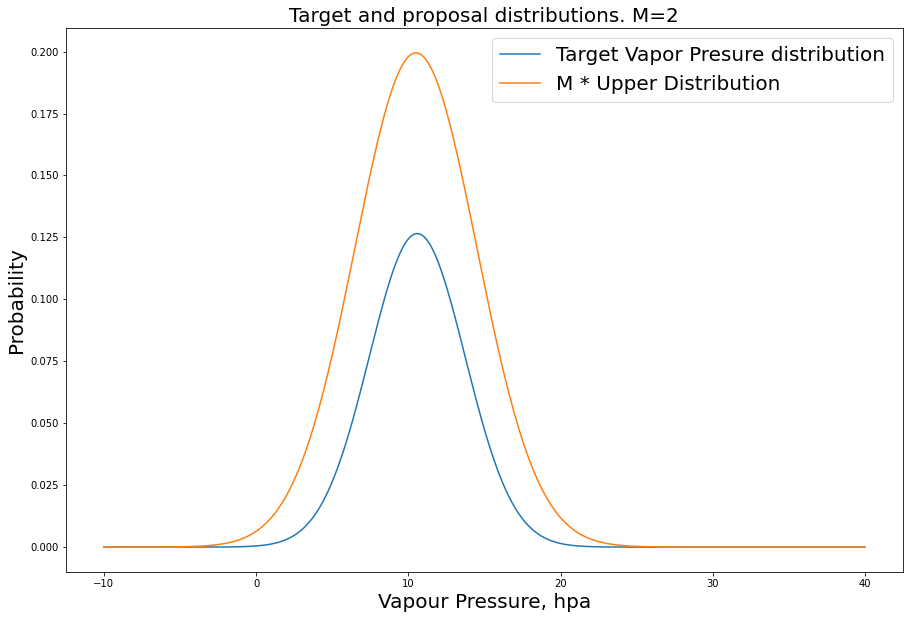

In [161]:
def g1(x, mu_, sigma_):
    return 1 / np.sqrt(2 * np.pi) / sigma_ * np.exp(-0.5 * ((x - mu_) / sigma_) ** 2)

def g(x, mu_, sigma_):
    return 1 / np.sqrt(2 * np.pi) / sigma_ * np.exp(-0.5 * ((x - mu_) / sigma_) ** 2)

M = 2

upper_params = 10.5, 4

plt.figure(figsize=(15, 10))
x_vals = np.arange(-10, 40, 0.01)
f_vals = [g1(x, 10.58677030758707, 3.152974324797822) for x in x_vals]
g_vals = g(x_vals, *upper_params)
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M * g_vals)
plt.xlabel('Vapour Pressure, hpa', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.legend(['Target Vapor Presure distribution', 'M * Upper Distribution'], fontsize=20)
plt.title("Target and proposal distributions. M=%s" % M, fontsize=20)
plt.savefig('Dist_vappor', bbox_inches='tight')
plt.show()

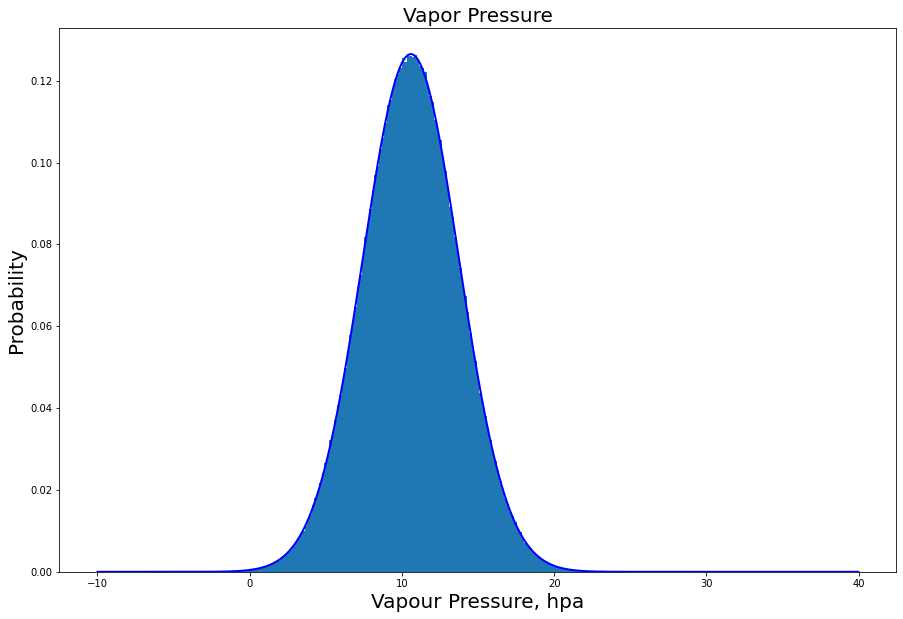

In [162]:
# collect all accepted samples here
samples = []

# try this many candidates
N = 4_000_000

for _ in range(N):
    # sample a candidate
    candidate = np.random.normal(*upper_params)

    # calculate probability of accepting this candidate
    prob_accept = g1(candidate, 10.58677030758707, 3.152974324797822) / (M * g(candidate, *upper_params))

    # accept with the calculated probability
    if np.random.random() < prob_accept:
        samples.append(candidate)

plt.figure(figsize=(15, 10))
plt.hist(samples, bins=200, density=True)
plt.xlabel('x', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.xlabel('Vapour Pressure, hpa', fontsize=20)
plt.plot(x_vals, [f for f in f_vals], linewidth=2, color='b')
plt.title("Vapor Pressure", fontsize=20)
plt.savefig('Dist_hist_vapor', bbox_inches='tight')
plt.show()

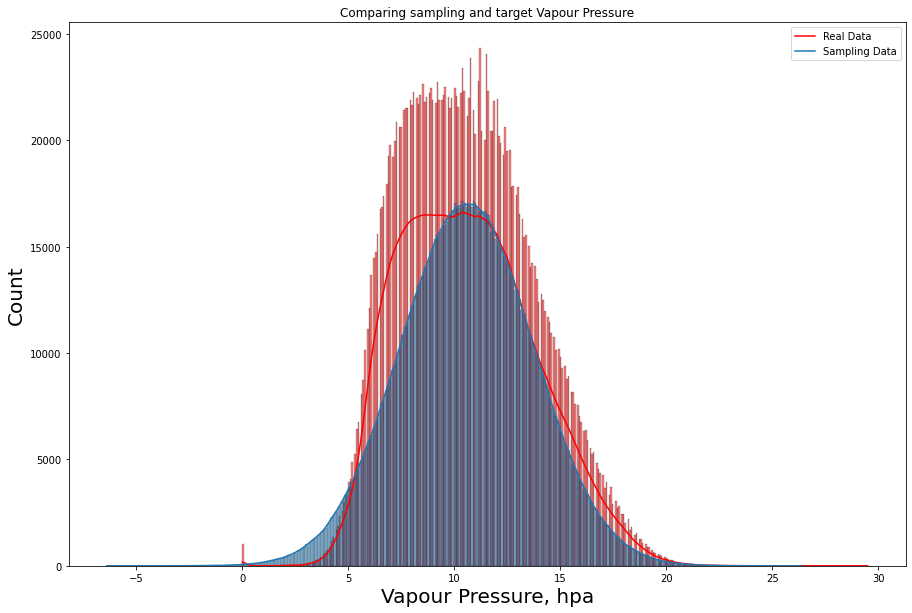

In [164]:
plt.figure(figsize=(15, 10))
sns.histplot(df['vappr'].values[:len(samples)], kde=True, color='red')
sns.histplot(samples, kde=True)
plt.legend(["Real Data", 'Sampling Data'])
plt.title(f"Comparing sampling and target Vapour Pressure")
plt.xlabel('Vapour Pressure, hpa', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.savefig('hist_vappor', bbox_inches='tight')
plt.show()

0.4514549149777399


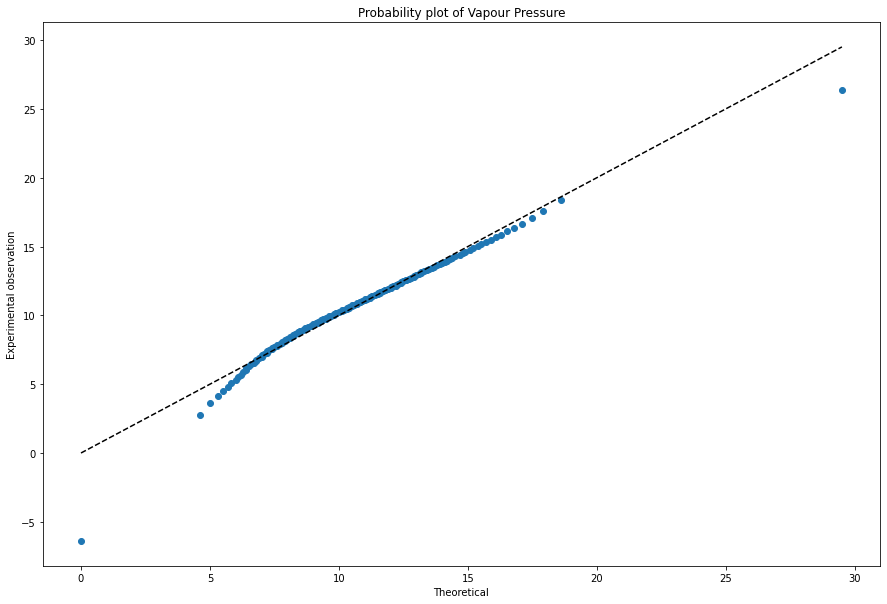

In [165]:
plt.figure(figsize=(15, 10))
percs = np.linspace(0, 100, 150)
qn_gt = np.percentile(df['vappr'].values[:len(samples)], percs)
p_stat, p_pv = scipy.stats.pearsonr(df['vappr'].values[:len(samples)], samples)
print(p_pv)
qn_sampled = np.percentile(samples, percs)
plt.plot(qn_gt, qn_sampled, ls="", marker="o", markersize=6)
plt.plot(qn_gt, qn_gt, color="k", ls="--")
plt.xlabel('Theoretical')
plt.ylabel('Experimental observation')
plt.title("Probability plot of Vapour Pressure")
plt.savefig('Probability_plot_vappr', bbox_inches='tight')
plt.show()

In [103]:
df['dewpt'].describe()

count    4.214711e+06
mean     7.262042e+00
std      4.461721e+00
min     -9.240000e+01
25%      4.000000e+00
50%      7.500000e+00
75%      1.060000e+01
max      2.380000e+01
Name: dewpt, dtype: float64

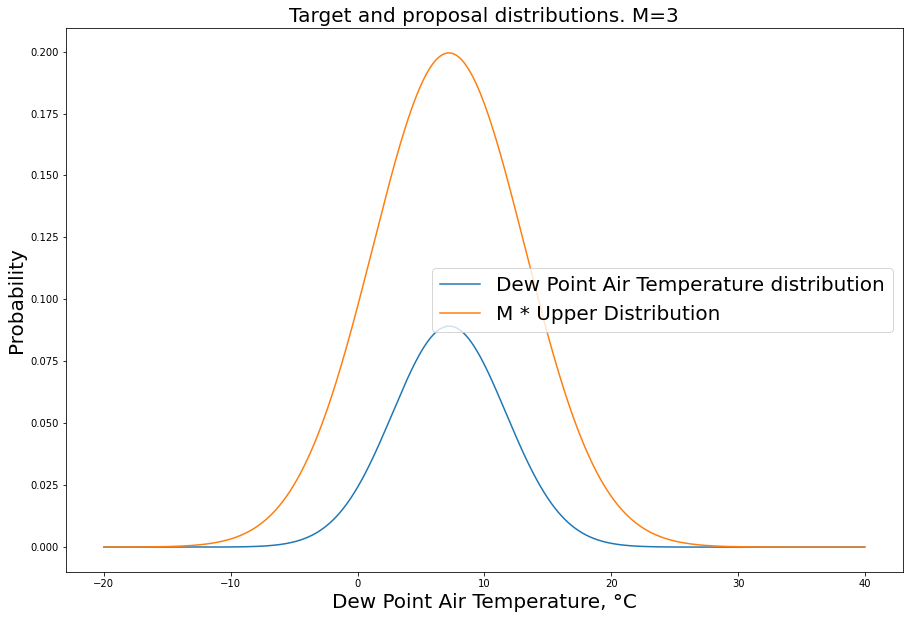

In [170]:
def g1(x, mu_, sigma_):
    return 1 / np.sqrt(2 * np.pi) / sigma_ * np.exp(-0.5 * ((x - mu_) / sigma_) ** 2)

def g(x, mu_, sigma_):
    return 1 / np.sqrt(2 * np.pi) / sigma_ * np.exp(-0.5 * ((x - mu_) / sigma_) ** 2)

M = 3

upper_params = 7.2, 6

plt.figure(figsize=(15, 10))
x_vals = np.arange(-20, 40, 0.01)
f_vals = [g1(x, 7.230309188564742, 4.47278497534584) for x in x_vals]
g_vals = g(x_vals, *upper_params)
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M * g_vals)
plt.xlabel('Dew Point Air Temperature, °C', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.legend(['Dew Point Air Temperature distribution', 'M * Upper Distribution'], fontsize=20)
plt.title("Target and proposal distributions. M=%s" % M, fontsize=20)
plt.savefig('Dist_dewpt', bbox_inches='tight')
plt.show()

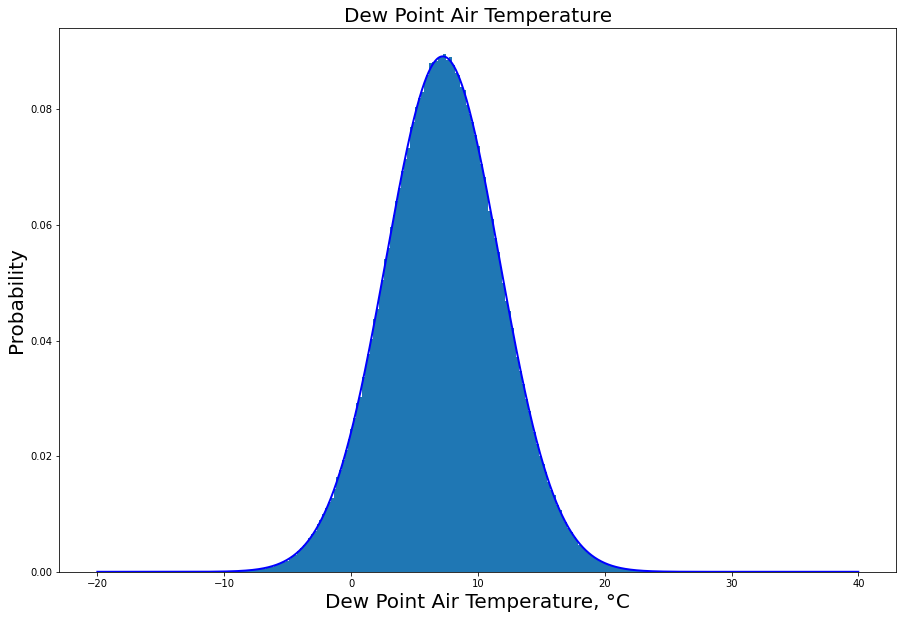

In [171]:
# collect all accepted samples here
samples = []

# try this many candidates
N = 4_000_000

for _ in range(N):
    # sample a candidate
    candidate = np.random.normal(*upper_params)

    # calculate probability of accepting this candidate
    prob_accept = g1(candidate, 7.230309188564742, 4.47278497534584) / (M * g(candidate, *upper_params))

    # accept with the calculated probability
    if np.random.random() < prob_accept:
        samples.append(candidate)

plt.figure(figsize=(15, 10))
plt.hist(samples, bins=200, density=True)
plt.ylabel('Probability', fontsize=20)
plt.xlabel('Dew Point Air Temperature, °C', fontsize=20)
plt.plot(x_vals, [f for f in f_vals], linewidth=2, color='b')
plt.title("Dew Point Air Temperature", fontsize=20)
plt.savefig('prob_dewpt', bbox_inches='tight')
plt.show()

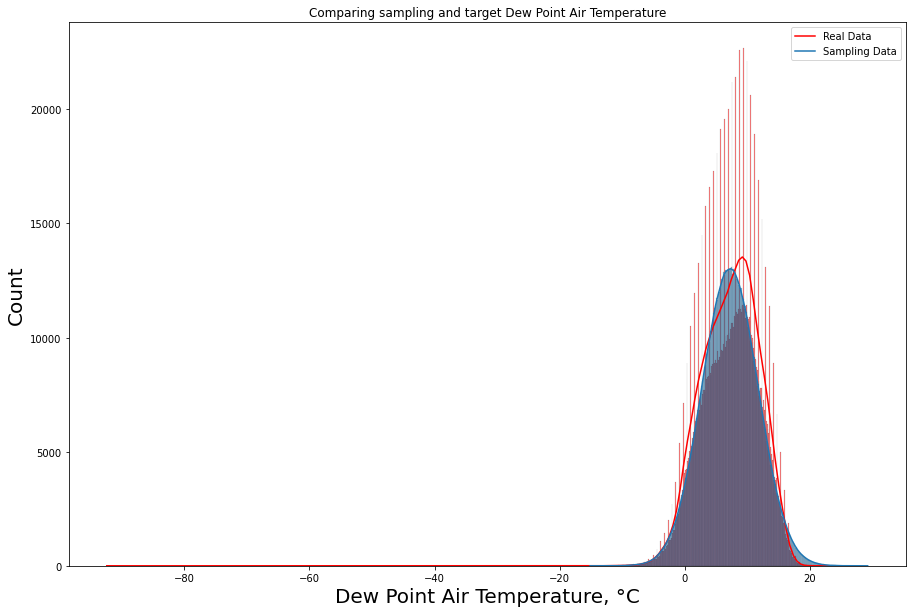

In [172]:
plt.figure(figsize=(15, 10))
sns.histplot(df['dewpt'].values[:len(samples)], kde=True, color='red')
sns.histplot(samples, kde=True)
plt.legend(["Real Data", 'Sampling Data'])
plt.title(f"Comparing sampling and target Dew Point Air Temperature")
plt.xlabel('Dew Point Air Temperature, °C', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.savefig('hist_dewpt', bbox_inches='tight')
plt.show()

0.8310701668490537


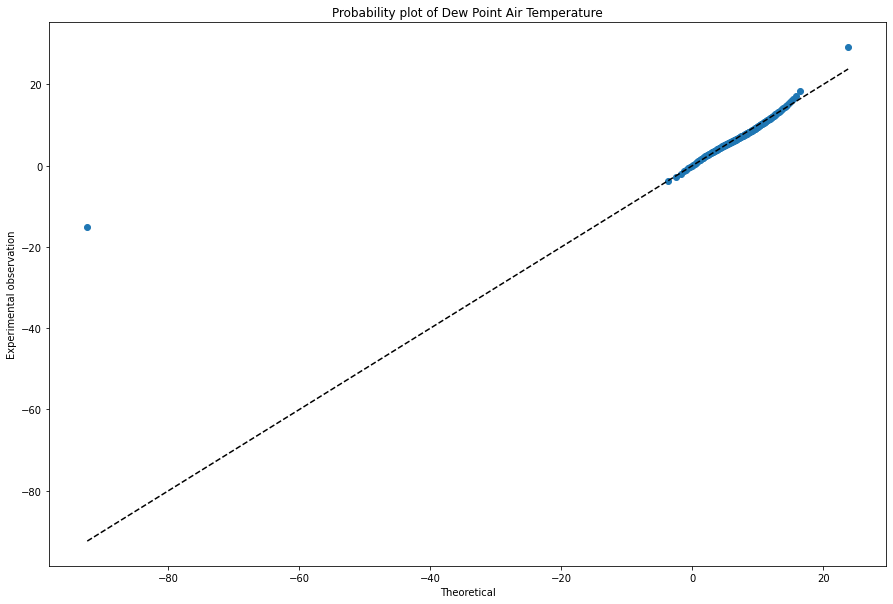

In [173]:
plt.figure(figsize=(15, 10))
percs = np.linspace(0, 100, 150)
qn_gt = np.percentile(df['dewpt'].values[:len(samples)], percs)
p_stat, p_pv = scipy.stats.pearsonr(df['dewpt'].values[:len(samples)], samples)
print(p_pv)
qn_sampled = np.percentile(samples, percs)
plt.plot(qn_gt, qn_sampled, ls="", marker="o", markersize=6)
plt.plot(qn_gt, qn_gt, color="k", ls="--")
plt.xlabel('Theoretical')
plt.ylabel('Experimental observation')
plt.title("Probability plot of Dew Point Air Temperature")
plt.savefig('Probability_plot_dewpt', bbox_inches='tight')
plt.show()

In [115]:
df['msl'].describe()

count    4.214711e+06
mean     1.013304e+03
std      1.258679e+01
min      9.432000e+02
25%      1.005600e+03
50%      1.014500e+03
75%      1.022100e+03
max      1.051200e+03
Name: msl, dtype: float64

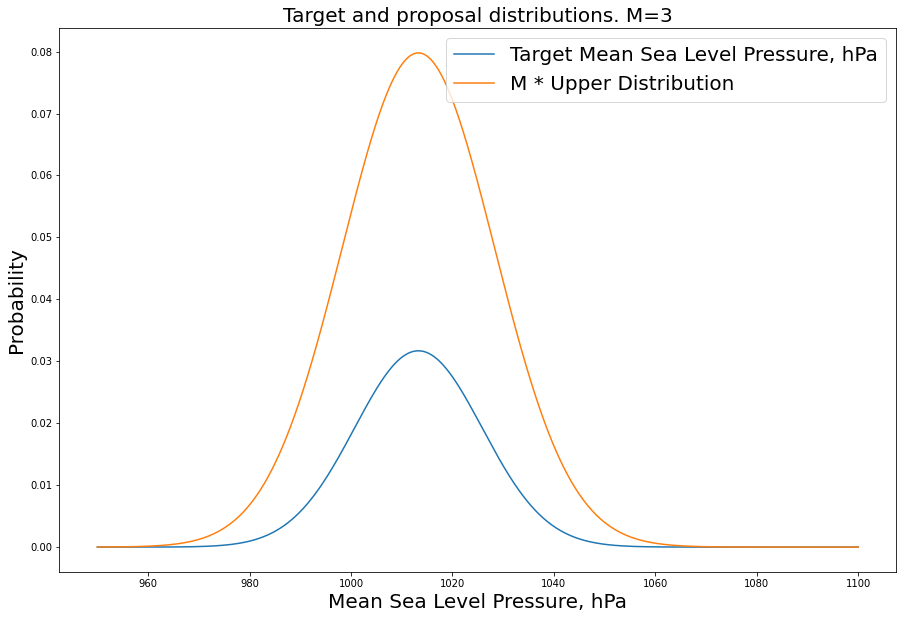

In [174]:
def g1(x, mu_, sigma_):
    return 1 / np.sqrt(2 * np.pi) / sigma_ * np.exp(-0.5 * ((x - mu_) / sigma_) ** 2)

def g(x, mu_, sigma_):
    return 1 / np.sqrt(2 * np.pi) / sigma_ * np.exp(-0.5 * ((x - mu_) / sigma_) ** 2)

M = 3

upper_params = 1013.28, 15

plt.figure(figsize=(15, 10))
x_vals = np.arange(950, 1100, 0.001)
f_vals = [g1(x, 1013.2813786209779, 12.587859921089885) for x in x_vals]
g_vals = g(x_vals, *upper_params)
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M * g_vals)
plt.xlabel('Mean Sea Level Pressure, hPa', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.legend(['Target Mean Sea Level Pressure, hPa', 'M * Upper Distribution'], fontsize=20)
plt.title("Target and proposal distributions. M=%s" % M, fontsize=20)
plt.savefig('Dist_msl', bbox_inches='tight')
plt.show()

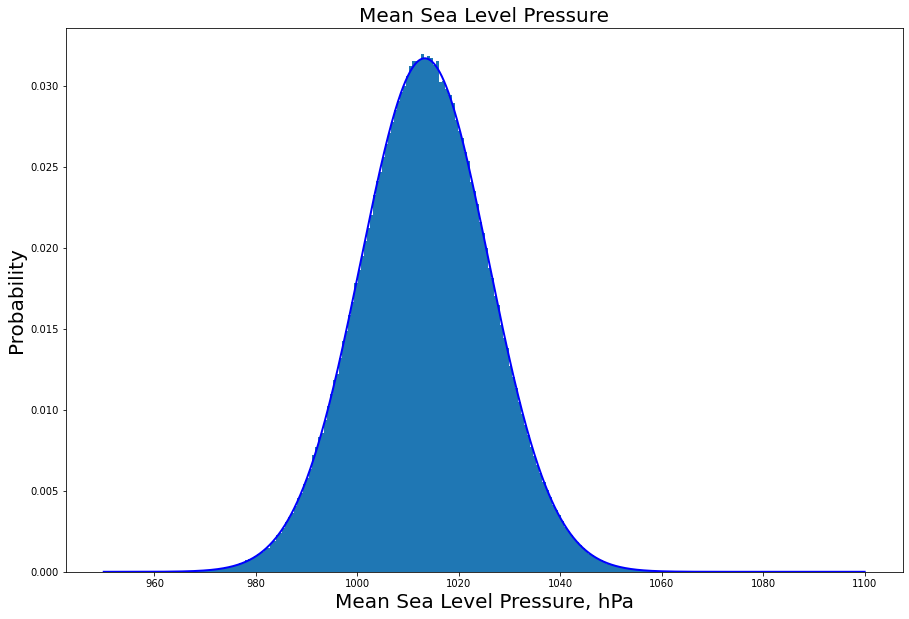

In [175]:
# collect all accepted samples here
samples = []

# try this many candidates
N = 4_000_000

for _ in range(N):
    # sample a candidate
    candidate = np.random.normal(*upper_params)

    # calculate probability of accepting this candidate
    prob_accept = g1(candidate, 1013.2813786209779, 12.587859921089885) / (M * g(candidate, *upper_params))

    # accept with the calculated probability
    if np.random.random() < prob_accept:
        samples.append(candidate)

plt.figure(figsize=(15, 10))
plt.hist(samples, bins=200, density=True)
plt.ylabel('Probability', fontsize=20)
plt.xlabel('Mean Sea Level Pressure, hPa', fontsize=20)
plt.plot(x_vals, [f for f in f_vals], linewidth=2, color='b')
plt.title("Mean Sea Level Pressure", fontsize=20)
plt.savefig('Distr_hist_msl', bbox_inches='tight')
plt.show()

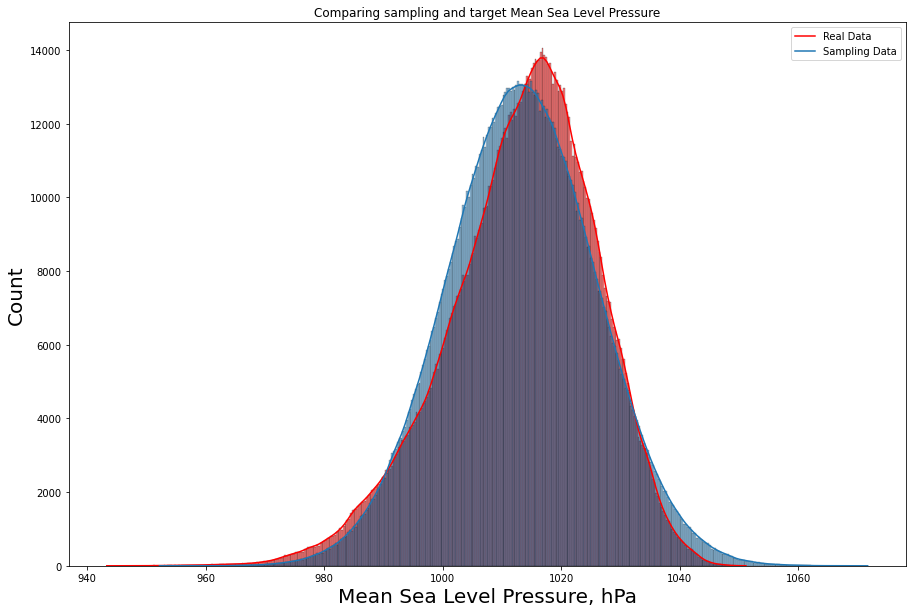

In [176]:
plt.figure(figsize=(15, 10))
sns.histplot(df['msl'].values[:len(samples)], kde=True, color='red')
sns.histplot(samples, kde=True)
plt.legend(["Real Data", 'Sampling Data'])
plt.title(f"Comparing sampling and target Mean Sea Level Pressure")
plt.xlabel('Mean Sea Level Pressure, hPa', fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.savefig('hist_msl', bbox_inches='tight')
plt.show()

0.5708574457992645


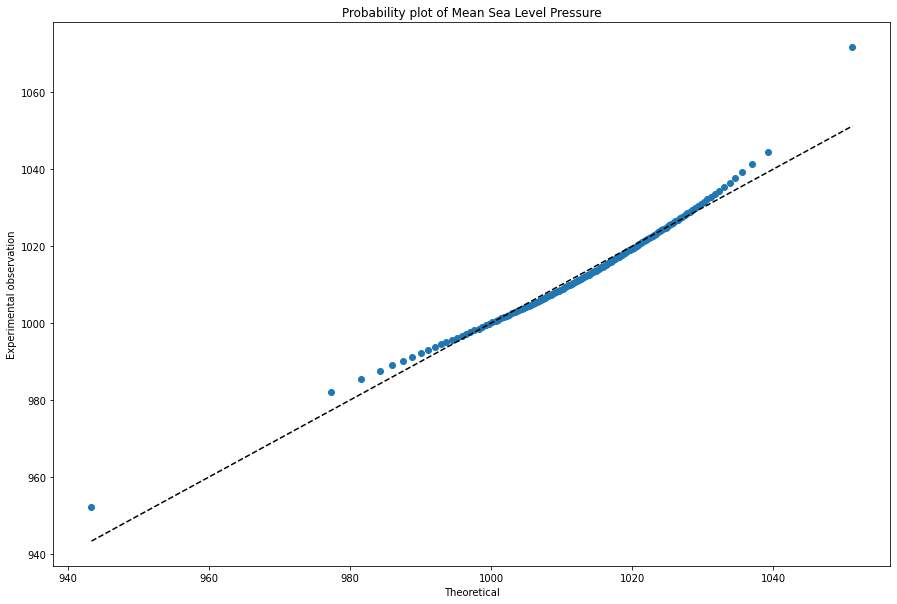

In [178]:
plt.figure(figsize=(15, 10))
percs = np.linspace(0, 100, 150)
qn_gt = np.percentile(df['msl'].values[:len(samples)], percs)
qn_sampled = np.percentile(samples, percs)
p_stat, p_pv = scipy.stats.pearsonr(df['msl'].values[:len(samples)], samples)
print(p_pv)
plt.plot(qn_gt, qn_sampled, ls="", marker="o", markersize=6)
plt.plot(qn_gt, qn_gt, color="k", ls="--")
plt.xlabel('Theoretical')
plt.ylabel('Experimental observation')
plt.title("Probability plot of Mean Sea Level Pressure")
plt.savefig('Probability_plot_msl', bbox_inches='tight')
plt.show()

C:\Users\gto_n\AppData\Local\Temp/ipykernel_25336/1551705049.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


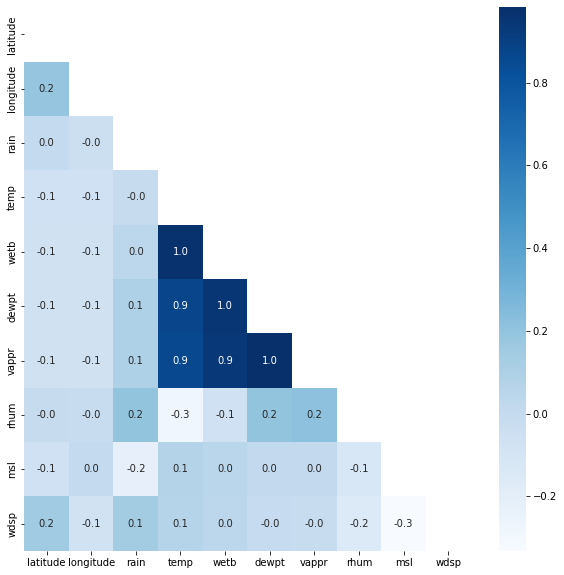

In [188]:
# Building a correlation matrix of features
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr, mask=mask, annot=True, fmt='.1f', ax=ax, cmap='Blues')
plt.savefig('corrcoefs', bbox_inches='tight')

## Baysessian

In [253]:
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling

from pgmpy.estimators import BicScore

from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import TreeSearch

from collections import Counter

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [254]:
def get_scores(data, samples):
    y_true = np.sort(data)
    y_pred = np.sort(samples)

    corr_matrix = np.corrcoef(y_true, y_pred)
    corr = corr_matrix[0,1]
    R_sq = corr**2

    print(f'R-2 score is: {R_sq}')
    print(f'RMSE is: {sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'MAE is: {mean_absolute_error(y_true, y_pred)}')

In [255]:
# modeling edges based on the analisys from step 3

model = BayesianModel([
    ('msl', 'wdsp'),
    ('vappr', 'wetb'),
    ('dewpt', 'wetb'),
    ('temp', 'rhum'),
    ('temp', 'wetb'),
    ('msl', 'rain')
])

C:\Users\gto_n\.conda\envs\raifhack_2021\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  warnings.warn(


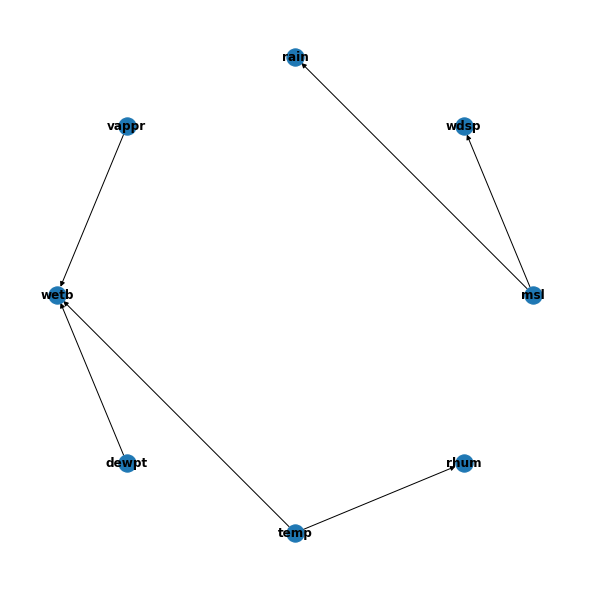

In [256]:
network = nx.DiGraph()
network.add_edges_from(model.edges())
pos = nx.layout.circular_layout(network)
plt.figure(figsize=(8, 8))
nx.draw(network, pos, with_labels=True, font_weight="bold")

In [257]:
df_trans = df.iloc[:, 2:].copy()

est = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
data_discr = est.fit_transform(df_trans.values[:, :])
df_trans[df_trans.columns[:]] = data_discr

df_prob = df_trans.iloc[:2000, :].copy()
df_trans = df_trans.iloc[2000:,:].copy()

In [261]:
model.fit(df_trans)

print(model.check_model())

True


In [262]:
k2_scores = {}

k2_scores["manual"] = K2Score(df_trans).score(model)
print(f"K2 score of hand-crafted model {K2Score(df_trans).score(model):.2f}")
print(f"BIC score of hand-crafted model {BicScore(df_trans).score(model):.2f}")

K2 score of hand-crafted model -36852166.90
BIC score of hand-crafted model -36854840.59


In [263]:
def sampling(bn: DAG, data: pd.DataFrame, n: int = 100, new: bool = False):
    if new:
        bn_new = BayesianModel(bn.edges())
        bn_new.fit(data)
    else:
        bn_new = bn
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n)
    return sample

In [264]:
df_s1 = sampling(model, df_prob, n=2000, new=True)
df_s1

C:\Users\gto_n\.conda\envs\raifhack_2021\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  warnings.warn(


  0%|          | 0/8 [00:00<?, ?it/s]

,msl,wdsp,rain,vappr,wetb,dewpt,temp,rhum
0,2.0,0.0,2.0,2.0,4.0,3.0,2.0,4.0
1,1.0,2.0,0.0,1.0,3.0,2.0,4.0,2.0
2,4.0,1.0,0.0,4.0,1.0,2.0,3.0,2.0
3,2.0,0.0,0.0,0.0,2.0,2.0,2.0,4.0
4,3.0,0.0,0.0,2.0,1.0,3.0,4.0,2.0
...,...,...,...,...,...,...,...,...
1995,2.0,1.0,0.0,0.0,4.0,4.0,1.0,4.0
1996,4.0,0.0,0.0,3.0,2.0,4.0,1.0,4.0
1997,4.0,1.0,0.0,3.0,2.0,1.0,3.0,2.0
1998,1.0,2.0,0.0,4.0,1.0,1.0,3.0,4.0


In [265]:
get_scores(df_trans['temp'].values[:2000], df_s1['temp'].values)

R-2 score is: 0.9728866160420752
RMSE is: 0.19621416870348585
MAE is: 0.0385


In [266]:
search = TreeSearch(df_trans, root_node="temp")
tree = search.estimate()

Building tree:   0%|          | 0/28.0 [00:00<?, ?it/s]

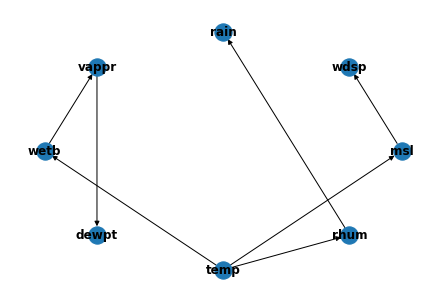

In [267]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(tree.edges())
nx.draw(G_K2, pos, with_labels=True, font_weight='bold')

In [268]:
k2_scores["tree"] = K2Score(df_trans).score(tree)

print(f"K2 score of tree model {K2Score(df_trans).score(tree):.2f}")
print(f"BIC score of tree model {BicScore(df_trans).score(tree):.2f}")

K2 score of tree model -30222601.52
BIC score of tree model -30222521.26


In [269]:
df_stree = sampling(tree, df_prob, n=2000, new=True)
get_scores(df_trans['temp'].values[:2000], df_stree['temp'].values)

C:\Users\gto_n\.conda\envs\raifhack_2021\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  warnings.warn(


  0%|          | 0/8 [00:00<?, ?it/s]

R-2 score is: 0.9664474479886345
RMSE is: 0.2202271554554524
MAE is: 0.0485


In [270]:
search = HillClimbSearch(df_trans)
k2_unconstr = search.estimate()

  0%|          | 0/1000000 [00:00<?, ?it/s]

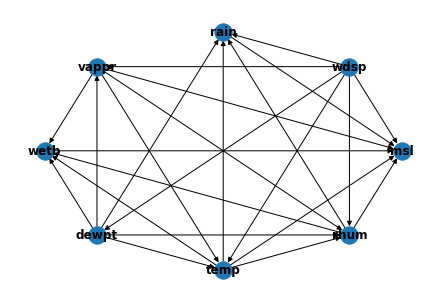

In [216]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(k2_unconstr.edges())
nx.draw(G_K2, pos, with_labels=True, font_weight='bold')

In [217]:
k2_scores["k2_unconstr"] = K2Score(df_trans).score(k2_unconstr)

print(f"K2 score of unconstrained model {K2Score(df_trans).score(k2_unconstr):.2f}")
print(f"BIC score of unconstrained model {BicScore(df_trans).score(k2_unconstr):.2f}")

K2 score of unconstrained model -27361251.96
BIC score of unconstrained model -27878696.67


In [219]:
df_k2c = sampling(k2_unconstr, df_prob, n=2000, new=True)
get_scores(df_trans['temp'].values[:2000], df_k2c['temp'].values)

C:\Users\gto_n\.conda\envs\raifhack_2021\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  warnings.warn(


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\gto_n\.conda\envs\raifhack_2021\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(


R-2 score is: 0.8635679675067283
RMSE is: 0.8709190547921202
MAE is: 0.7585


add constraints to our model
['latitude', 'longitude', 'rain', 'wetb', 'rhum', 'wdsp']

In [271]:
blacklist = []
blacklist.extend([(x, y) for x in df_trans.columns.to_list() for y in ['latitude', 'longitude', 'rain', 'wetb', 'rhum', 'wdsp'] if x != y])
blacklist.extend([(y, x) for x in df_trans.columns.to_list() for y in ['temp', 'vappr', 'dewpt', 'msl']])

In [272]:
search = HillClimbSearch(df_trans)
k2_constr = search.estimate(black_list=blacklist)

  0%|          | 0/1000000 [00:00<?, ?it/s]

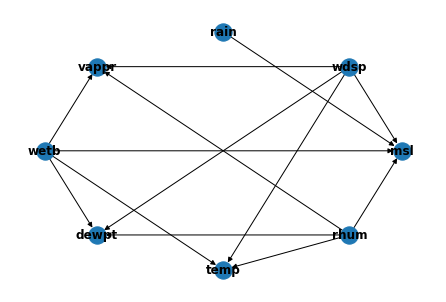

In [273]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(k2_constr.edges())
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')

In [274]:
k2_scores["k2_constr"] = K2Score(df_trans).score(k2_constr)

print(f"K2 score of unconstrained model {K2Score(df_trans).score(k2_constr):.2f}")
print(f"BIC score of unconstrained model {BicScore(df_trans).score(k2_constr):.2f}")

K2 score of unconstrained model -29382432.65
BIC score of unconstrained model -29402520.26


In [275]:
df_k2c = sampling(k2_constr, df_trans, n=2000, new=True)

C:\Users\gto_n\.conda\envs\raifhack_2021\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  warnings.warn(


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\gto_n\.conda\envs\raifhack_2021\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(


## Prediction for temp

In [280]:
from tqdm import tqdm
def fit_predict_network(network, df_train, df_test, target_variable):
    bn_new = BayesianModel(network.edges())
    bn_new.fit(df_train)
    X_test = df_test[list(bn_new.nodes())].drop(target_variable, axis=1)
    scores = bn_new.predict_probability(X_test).values

    y_true = df_test[[target_variable]].values
    ohe = preprocessing.OneHotEncoder()
    y_true = ohe.fit_transform(y_true).toarray()
    try:
        auc = metrics.roc_auc_score(y_true, scores, multi_class='ovr', average="weighted")
    except ValueError:
        auc = None

    return auc


def scoring_model(network, data, target_variable="temp"):
    data = data.sample(frac=1).reset_index(drop=True)
    df_train = data.iloc[:800, :]
    df_test = data.iloc[800:, :]
    auc = fit_predict_network(network, df_train, df_test, target_variable=target_variable)
    print(auc)

    return auc

In [281]:
data_aucs = {}

for net_name, net_arch in tqdm(zip(
        ["manual", "tree", "unconstrained", "constrained"],
        [model, tree, k2_unconstr, k2_constr]
), total=4, desc="Models"):
    aucs = scoring_model(net_arch, df_trans.iloc[:1000, :])
    data_aucs[net_name] = aucs

Models:   0%|          | 0/4 [00:00<?, ?it/s]C:\Users\gto_n\.conda\envs\raifhack_2021\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  warnings.warn(
Models:  25%|██▌       | 1/4 [00:06<00:18,  6.25s/it]

0.8242023774658618


C:\Users\gto_n\.conda\envs\raifhack_2021\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  warnings.warn(
Models:  50%|█████     | 2/4 [00:08<00:07,  3.86s/it]

0.8898068766957087


C:\Users\gto_n\.conda\envs\raifhack_2021\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  warnings.warn(
C:\Users\gto_n\.conda\envs\raifhack_2021\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:466: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi.values.sum()
Models:  75%|███████▌  | 3/4 [17:37<08:01, 481.16s/it]

None


C:\Users\gto_n\.conda\envs\raifhack_2021\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  warnings.warn(
Models: 100%|██████████| 4/4 [18:11<00:00, 272.80s/it]

0.9200255171923536


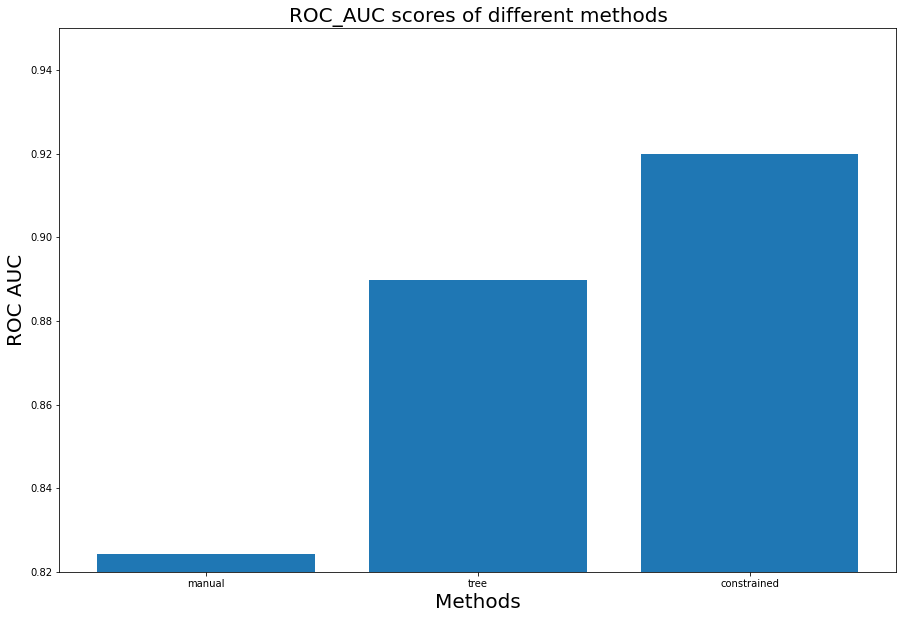

In [289]:
plt.figure(figsize=(15, 10))
x = ["manual", "tree", "constrained"]
y = [0.8242023774658618, 0.8898068766957087, 0.9200255171923536]
plt.bar(x,y)
plt.title('ROC_AUC scores of different methods', fontsize=20)
plt.xlabel('Methods', fontsize=20)
plt.ylabel('ROC AUC', fontsize=20)
plt.ylim(0.82,0.95)
plt.savefig('ROC_AUC scores of different methods_scale', bbox_inches='tight')
plt.show()

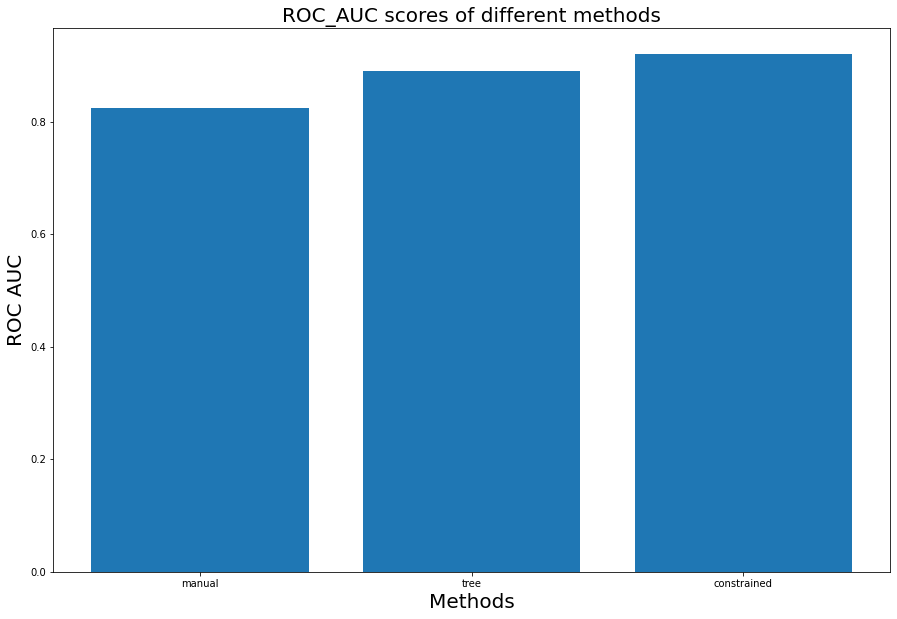

In [290]:
plt.figure(figsize=(15, 10))
x = ["manual", "tree", "constrained"]
y = [0.8242023774658618, 0.8898068766957087, 0.9200255171923536]
plt.bar(x,y)
plt.title('ROC_AUC scores of different methods', fontsize=20)
plt.xlabel('Methods', fontsize=20)
plt.ylabel('ROC AUC', fontsize=20)
plt.savefig('ROC_AUC scores of different methods', bbox_inches='tight')
plt.show()